<a href="https://colab.research.google.com/github/nedokormysh/DP_NLP_bootcamp/blob/classification/Fontanka_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Загрузка данных

In [ ]:
df = pd.DataFrame()

for i in range(1, 13):
    df_ = pd.read_csv(f'https://raw.githubusercontent.com/nedokormysh/DP_NLP_bootcamp/parsing/data/fontanka_full_{i}.csv')
    df = pd.concat([df, df_])

In [ ]:
df.drop_duplicates();
# df.to_csv('df_fontanka_2022.csv')

In [ ]:
# Удаляем пропуски
df.dropna(inplace=True)

In [ ]:
df.shape

(26515, 6)

In [ ]:
# Переводим тэги к нижнему регистру
df['topic']= df['topic'].apply(lambda x: x.lower())

Изначальный анализ данных проводился на здесь https://github.com/nedokormysh/DP_NLP_bootcamp/tree/parsing

In [ ]:
# Размер каждой категории
df.topic.value_counts()

общество            7341
происшествия        7248
город               4742
власть              2186
бизнес              1155
спорт                980
строительство        893
политика             598
финансы              418
авто                 265
технологии           241
туризм               128
доброе дело          117
недвижимость          86
образ жизни           50
жкх                   15
доктор питер          15
финляндия             12
новости компаний      12
особое мнение         10
работа                 3
Name: topic, dtype: int64

У нас очень мало статей по темам: жкх, доктор питер, финляндия, новости компаний, особое мнение, работа.

Для подобной несбалансированной выборки необходимо увеличивать количество данных.

Поместим эти темы в одну: "разное".

In [ ]:
df['topic'] = df['topic'].apply(lambda x: 'разное' if x in ['жкх',
                                                            'доктор питер',
                                                            'финляндия',
                                                            'новости компаний',
                                                            'особое мнение',
                                                            'работа'] else x)

In [ ]:
df.topic.value_counts()

общество         7341
происшествия     7248
город            4742
власть           2186
бизнес           1155
спорт             980
строительство     893
политика          598
финансы           418
авто              265
технологии        241
туризм            128
доброе дело       117
недвижимость       86
разное             67
образ жизни        50
Name: topic, dtype: int64

# Предобработка текстов.

In [ ]:
RND_STATE = 7575

In [ ]:
!pip install natasha -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

Функция для обработки текстов.

In [ ]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [ ]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: user 27min 6s, sys: 16min 19s, total: 43min 25s
Wall time: 26min 51s


Сравнение изначального текста и текста после предобработки.

In [ ]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Угадайте где. Петербург привели в порядок к ПМЭФ',
        'угадайте петербург привести порядок пмэф']], dtype=object)

In [ ]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['Кировский райсуд Петербурга огласил приговор Юрию Ильичу, которого признали виновным в сходе шести вагонов с калием на железнодорожной станции Автово. Ущерб из-за «преступной небрежности» превысил миллион рублей, но виновник очень хорошо себя зарекомендовал.О подробностях дела сообщает 3 июня объединенная пресс-служба городских судов. Ильич работал дорожным мастером Санкт-Петербург-Балтийской дистанции пути РЖД, но в сентябре прошлого года заменял контролера состояния пути, ушедшего в отпуск. 16-го числа он не выявил неисправности пути на станции Автово, и через три дня там произошла авария: при проезде 64 вагонов передние колеса одного из них провалились в колею. В итоге с пути сошли шесть грузовых вагонов с хлористым калием, принадлежавшим ПАО «Уралкалий». Компания получила ущерб в 1 миллион и 186 тысяч рублей, а РЖД — почти в 42 тысячи рублей. Виновнику вменили ч. 1 ст. 263 УК РФ, максимальное наказание по которой — до двух лет лишения свободы. Ильич вину полностью признал,

# Word2Vec

In [ ]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=300,
                 min_count=10,
                 window=5,
                 seed=RND_STATE)

In [ ]:
model.wv.most_similar(positive=["финляндия"])

[('сша', 0.9925740957260132),
 ('путин', 0.9912326335906982),
 ('заявить', 0.9903085231781006),
 ('переговоры', 0.987646222114563),
 ('мид', 0.9872540235519409),
 ('нато', 0.9867738485336304),
 ('страна', 0.98537278175354),
 ('российский', 0.984893262386322),
 ('россия', 0.9848846197128296),
 ('россиянин', 0.9848679900169373)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=300,
                 min_count=10,
                 window=5,
                 seed=RND_STATE)

# Логистическая регрессия

## MeanEmbedding + Логистическая регрессия

Усредняем все слова в предложении.

In [ ]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [ ]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000,
                                            class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.20      0.79      0.33        58
       бизнес       0.43      0.60      0.50       277
       власть       0.43      0.40      0.42       552
        город       0.73      0.61      0.66      1182
  доброе дело       0.24      0.85      0.37        26
 недвижимость       0.25      0.74      0.38        19
  образ жизни       0.05      0.58      0.09        12
     общество       0.69      0.32      0.43      1841
     политика       0.19      0.61      0.29       134
 происшествия       0.84      0.79      0.81      1858
       разное       0.07      0.43      0.12        21
        спорт       0.81      0.93      0.87       234
строительство       0.90      0.84      0.87       216
   технологии       0.19      0.66      0.29        62
       туризм       0.10      0.68      0.17        28
      финансы       0.44      0.74      0.55       109

     accuracy                           0.58      6629
    macr

Видно, что качество определения невысокое. На мой взгляд хуже обстоят дела с точностью, чем с полнотой. При этом, если не добавлять параметр: class_weight, то мы по некоторым топикам в принципе не будем обнаруживать статьи.

## TF-IDF + Логистическая регрессия

In [ ]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
pipe = Pipeline([('tfidf', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced'))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.22      0.76      0.34        58
       бизнес       0.41      0.58      0.48       277
       власть       0.42      0.42      0.42       552
        город       0.71      0.63      0.67      1182
  доброе дело       0.26      0.88      0.40        26
 недвижимость       0.27      0.63      0.38        19
  образ жизни       0.07      0.58      0.12        12
     общество       0.68      0.33      0.44      1841
     политика       0.19      0.57      0.28       134
 происшествия       0.83      0.78      0.80      1858
       разное       0.08      0.43      0.13        21
        спорт       0.83      0.94      0.88       234
строительство       0.91      0.91      0.91       216
   технологии       0.17      0.56      0.26        62
       туризм       0.12      0.75      0.21        28
      финансы       0.43      0.73      0.54       109

     accuracy                           0.59      6629
    macr

Качество модели улучшилось несильно. Всё также точность определения не слишком высокая.

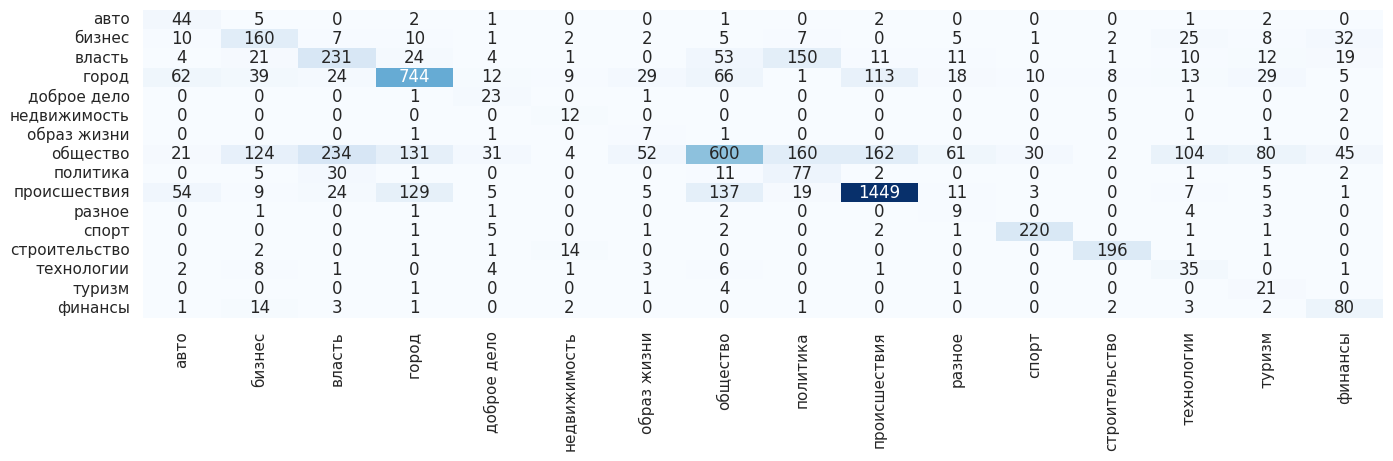

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

## FastText + Логистическая регрессия


In [ ]:
from gensim.models.fasttext import FastText

In [ ]:
model_fast = FastText(sentences=X_train,
                 vector_size=300,
                 min_count=10,
                 window=10,
                 seed=RND_STATE)

In [ ]:
pipe = Pipeline([('fast', TfidfEmbeddingVectorizer(model_fast)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced'
                                            ))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.21      0.81      0.34        58
       бизнес       0.45      0.60      0.51       277
       власть       0.39      0.39      0.39       552
        город       0.70      0.61      0.66      1182
  доброе дело       0.22      0.77      0.34        26
 недвижимость       0.19      0.58      0.29        19
  образ жизни       0.02      0.17      0.03        12
     общество       0.67      0.32      0.43      1841
     политика       0.19      0.58      0.28       134
 происшествия       0.84      0.78      0.81      1858
       разное       0.08      0.57      0.15        21
        спорт       0.81      0.92      0.86       234
строительство       0.90      0.86      0.88       216
   технологии       0.20      0.65      0.30        62
       туризм       0.10      0.57      0.17        28
      финансы       0.44      0.74      0.55       109

     accuracy                           0.58      6629
    macr

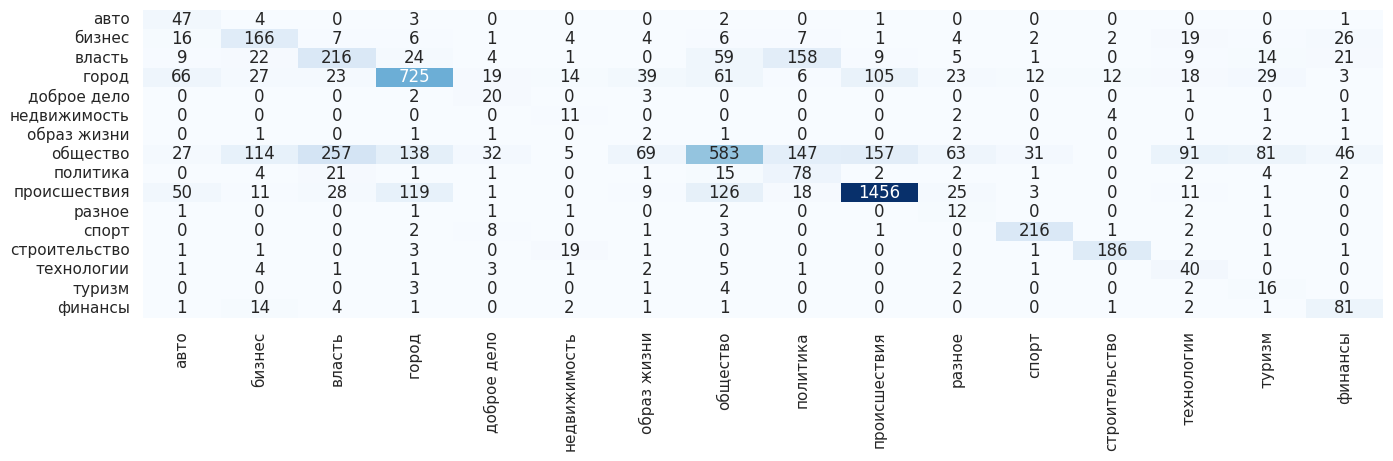

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

# Catboost

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            # depth=6,
                                            # auto_class_weights='Balanced',
                                            # loss_function='MultiClass',
                                            verbose=False))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

               precision    recall  f1-score   support

         авто       0.59      0.34      0.43        58
       бизнес       0.50      0.49      0.50       277
       власть       0.54      0.41      0.47       552
        город       0.74      0.70      0.72      1182
  доброе дело       0.69      0.69      0.69        26
 недвижимость       0.50      0.05      0.10        19
  образ жизни       0.00      0.00      0.00        12
     общество       0.61      0.68      0.64      1841
     политика       0.54      0.31      0.39       134
 происшествия       0.82      0.88      0.85      1858
       разное       0.50      0.05      0.09        21
        спорт       0.92      0.90      0.91       234
строительство       0.87      0.95      0.91       216
   технологии       0.67      0.29      0.40        62
       туризм       0.67      0.21      0.32        28
      финансы       0.64      0.50      0.56       109

     accuracy                           0.70      6629
    macr

# Выводы

* какие-то статьи близки по тематикам (для примера: ошибки в теме строительства - статьи определялись в темах город, финансы и недвижимость)

* но больше всего на результат влияет, что данные сильно несбалансированы. На некоторые темы набралось слишком маленькое количество статей. Насколько я понял, то решением данной проблемы может быть только парсинг и скрапинг.

Впрочем, это, собственно и главный вопрос, что делать. Некоторые темы: например, особое мнение - не совсем является тематикой. А скорее отдельной рубрикой, под которой могут прятаться разные

* результаты классификаторов достаточно неважные. Лучше всего себя показала модель Catboost.

* при этом не делался подбор гиперпараметров. Возможно стоит попробовать ансамблирование.



Не совсем понятно, что лучше сделать в такой ситуации. Может быть объединять схожие темы? Или действительно просто набирать статьи за максимально большее количество времени? Или пытаться строить более сложные модели?